In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

## Models trained using a PMG mask

Since the PMG and CF regions become distorted during simulations, here we would like to use a myosin PCA that doesn't consider those troublesome regions

(236, 200)


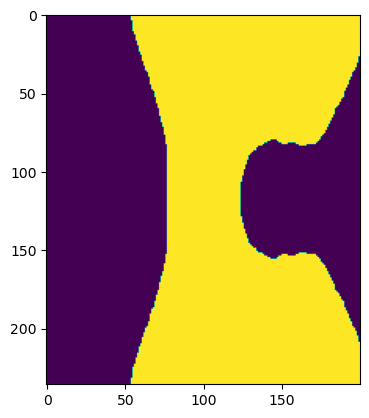

In [ ]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = np.array(Image.open('../flydrive/Masks/MAX_WT_PMG_mask.tiff'))
cf_mask = np.array(Image.open('../flydrive/Masks/MAX_WT_CF_mask.tiff'))

pmg_mask = np.array(pmg_mask)
cf_mask = np.array(cf_mask)
total_mask = resize(pmg_mask + cf_mask, (236, 200))
total_mask = (total_mask + total_mask[::-1]) > 0
n = 3
total_mask = ~binary_erosion(total_mask, np.ones([n, n]))
total_mask
print(total_mask.shape)
plt.imshow(total_mask)
np.save('../flydrive/Masks/pmg_cf_mask', total_mask)

## Build PCA models from datasets

In [94]:
from mutant_datasets import *
wt = WTDataset()

sqh = []
vel = []
time = []

for eId in wt.df.embryoID.unique():
    m, v, t = wt.get_trajectory(eId)
    sqh.append(m)
    vel.append(v)
    time.append(t)

twist = TwistDataset()
for eId in twist.df.embryoID.unique():
    m, v, t = twist.get_trajectory(eId)
    sqh.append(m)
    vel.append(v)
    time.append(t)

toll = TollDataset(tmax=30)
for eId in toll.df.embryoID.unique():
    m, v, t = toll.get_trajectory(eId)
    sqh.append(m)
    vel.append(v)
    time.append(t)

spz = SpaetzleDataset(tmax=30)
for eId in spz.df.embryoID.unique():
    m, v, t = spz.get_trajectory(eId)
    sqh.append(m)
    vel.append(v)
    time.append(t)

sqh = np.concatenate(sqh)
vel = np.concatenate(vel)
time = np.concatenate(time)
print(sqh.shape, vel.shape, time.shape)
sqh = sqh.reshape([-2, 4, 236, 200])

100%|██████████| 4/4 [00:00<00:00, 3353.43it/s]


(734, 2, 2, 236, 200) (734, 2, 236, 200) (734,)


In [95]:
from morphogenesis.decomposition.decomposition_model import SVDPipeline

pmg_cf_mask = np.load('../flydrive/Masks/pmg_cf_mask.npy')
sqh_model = SVDPipeline(whiten=True, crop=40, mask=pmg_cf_mask)
scaler_train = sqh[time < 0]
sqh_model.fit(sqh, scaler_train)

vel_model = SVDPipeline(whiten=True, crop=0)
scaler_train = np.zeros([1, 2, 236, 200])
vel_model.fit(vel, scaler_train)

import pickle
with open('MutantSqhSVD.pkl', 'wb') as f:
    pickle.dump(sqh_model, f)

with open('MutantVelSVD.pkl', 'wb') as f:
    pickle.dump(vel_model, f)


(734, 16) (734, 16)


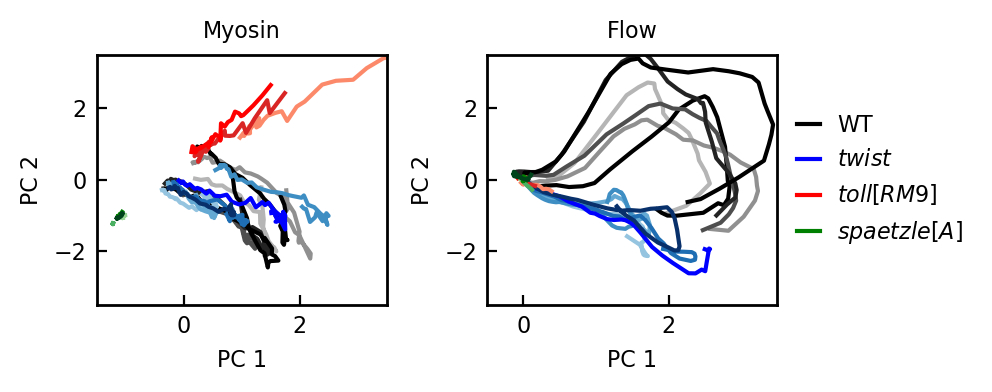

In [103]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_scalar, plot_tensor
from morphogenesis.dataset import *

plt.rcParams['axes.linewidth'] = 1

fig, ax = plt.subplots(1, 2, figsize=(5, 2), dpi=200)


X = []
y0 = []
colors = plt.cm.Greys(np.linspace(0.4, 1, len(wt.df.embryoID.unique())))
for i, eId in enumerate(wt.df.embryoID.unique()):
    m, v, t = wt.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = vel_model.transform(v)

    if i == 2:
        ax[0].plot(sqh[:,0], sqh[:,1], color='black', label='WT')#c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], color='black', label='WT')#c=colors[i])
    else:
        ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], c=colors[i])
    
    X.append(sqh)
    y0.append(vel)

colors = plt.cm.Blues(np.linspace(0.4, 1, len(twist.df.embryoID.unique())))
for i, eId in enumerate(twist.df.embryoID.unique()):
    m, v, t = twist.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = vel_model.transform(v)

    if i == 4:
        ax[0].plot(sqh[:,0], sqh[:,1], color='blue', label='$twist$')#c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], color='blue', label='$twist$')#c=colors[i])
    else:
        ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

    X.append(sqh)
    y0.append(vel)

colors = plt.cm.Reds(np.linspace(0.4, 1, len(toll.df.embryoID.unique())))
for i, eId in enumerate(toll.df.embryoID.unique()):
    m, v, t = toll.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = vel_model.transform(v)

    if i == 2:
        ax[0].plot(sqh[:,0], sqh[:,1], color='red', label='$toll[RM9]$')#c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], color='red', label='$toll[RM9]$')#c=colors[i])
    else:
        ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

    X.append(sqh)
    y0.append(vel)

colors = plt.cm.Greens(np.linspace(0.4, 1, len(spz.df.embryoID.unique())))
for i, eId in enumerate(spz.df.embryoID.unique()):
    m, v, t = spz.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = vel_model.transform(v)

    if i == 2:
        ax[0].plot(sqh[:,0], sqh[:,1], color='green', label='$spaetzle[A]$')#c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], color='green', label='$spaetzle[A]$')#c=colors[i])
    else:
        ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
        ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

    X.append(sqh)
    y0.append(vel)

X = np.concatenate(X)
y0 = np.concatenate(y0)
print(X.shape, y0.shape)

ax[0].set(xlim=[-1.5, 3.5], xticks=[0, 2], 
          ylim=[-3.5, 3.5], yticks=[-2, 0, 2],
          xlabel='PC 1', ylabel='PC 2');
ax[1].set(xlim=[-0.5, 3.5], xticks=[0, 2], 
          ylim=[-3.5, 3.5], yticks=[-2, 0, 2],
          xlabel='PC 1', ylabel='PC 2');

ax[0].set_title('Myosin')
ax[1].set_title('Flow')

ax[1].legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0, handlelength=1.0)

plt.tight_layout()

(550, 16) (550, 16)


Text(0.5, 1.0, 'Flow')

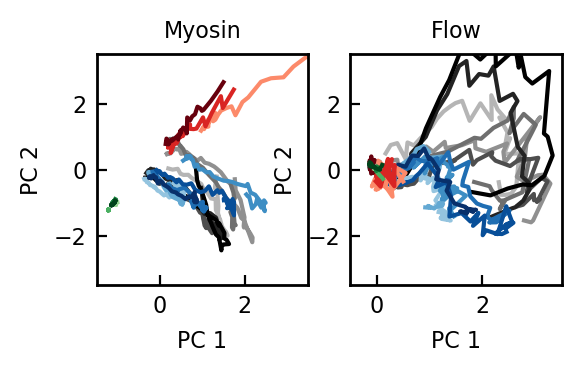

In [104]:
from sklearn.model_selection import train_test_split
X_train, _, y0_train, _ = train_test_split(X, y0, test_size=0.25, random_state=0)

print(X_train.shape, y0_train.shape)

from sklearn.kernel_ridge import KernelRidge

keep=4
model = KernelRidge(kernel='polynomial', alpha=2.).fit(X_train[:, :keep], y0_train[:, :keep])

import pickle
with open('MutantKernelRidge.pkl', 'wb') as f:
    pickle.dump(model, f)


fig, ax = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)

colors = plt.cm.Greys(np.linspace(0.4, 1, len(wt.df.embryoID.unique())))
for i, eId in enumerate(wt.df.embryoID.unique()):
    m, v, t = wt.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = model.predict(sqh[:, :keep])

    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i])


colors = plt.cm.Blues(np.linspace(0.4, 1, len(twist.df.embryoID.unique())))
for i, eId in enumerate(twist.df.embryoID.unique()):
    m, v, t = twist.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = model.predict(sqh[:, :keep])
    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

colors = plt.cm.Reds(np.linspace(0.4, 1, len(toll.df.embryoID.unique())))
for i, eId in enumerate(toll.df.embryoID.unique()):
    m, v, t = toll.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = model.predict(sqh[:, :keep])
    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

colors = plt.cm.Greens(np.linspace(0.4, 1, len(spz.df.embryoID.unique())))
for i, eId in enumerate(spz.df.embryoID.unique()):
    m, v, t = spz.get_trajectory(eId)
    sqh = sqh_model.transform(m)
    vel = vel_model.transform(v)
    ax[0].plot(sqh[:,0], sqh[:,1], c=colors[i])
    ax[1].plot(vel[:,0], vel[:,1], c=colors[i])

ax[0].set(xlim=[-1.5, 3.5], xticks=[0, 2], 
          ylim=[-3.5, 3.5], yticks=[-2, 0, 2],
          xlabel='PC 1', ylabel='PC 2');
ax[1].set(xlim=[-0.5, 3.5], xticks=[0, 2], 
          ylim=[-3.5, 3.5], yticks=[-2, 0, 2],
          xlabel='PC 1', ylabel='PC 2');

ax[0].set_title('Myosin')
ax[1].set_title('Flow')

In [105]:
print(np.cumsum(sqh_model['svd'].explained_variance_ratio_)[:5],
      np.cumsum(vel_model['svd'].explained_variance_ratio_)[:5])


[0.88416189 0.93677242 0.96614275 0.97766636 0.98154399] [0.74064741 0.84345666 0.90113736 0.92217223 0.93564743]
